### E-commerce — customer segmentation
This dataset contains transactions of an online store selling goods for home and decore. 

We need to segment users by consumption profile, so we need:

- conduct EDA 

- We need to segment customers based on the history of their purchases. As primary tool for segmentation there will be used RFM analysis, which clusters customers based on how recent they interacted with the product, how frequently they do it and how much income they generate. Also, as the clustering algorithm there will be used KMeans. 

- hypotheses testing that the cluster are significantly different in the amount of money they spend , что наши сегменты статистически значимо отличаются друг от друга

**The table of content:**

- [EDA and data preprocessing](#step1)

- [Segmentation according to percentiles (Recency, Frequency, Monetary)](#step2)

- [Data preprocessing for KMeans](#step3)

- [Clustering with KMeans](#step4)

- [Hyporheses testing that the segments do not significantly differ](#step5)

###  EDA and data preprocessing (if needed) <a id='step1'></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings 
warnings.filterwarnings('ignore')
from datetime import timedelta
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import scipy as sp 
from scipy import stats as st
import datetime

In [2]:
# loading data and changing dates format
df = pd.read_csv('ecommerce_dataset.csv')
df['date'] = df['date'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d%H'))

In [3]:
# let's look at the data

def info_head_describe_duplicates(df):
    display(df.info())
    print('')
    print('-----------------------------------------------------------------')
    print('')
    display(df.head())
    print('')
    print('-----------------------------------------------------------------')
    print('')
    display(df.describe())
    print('')
    print('-----------------------------------------------------------------')
    print('')
    display(df.duplicated().sum())

In [4]:
info_head_describe_duplicates(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 315.9+ KB


None


-----------------------------------------------------------------



,date,customer_id,order_id,product,quantity,price
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0



-----------------------------------------------------------------



,order_id,quantity,price
count,6737.000000,6737.000000,6737.000000
mean,43128.948345,2.501559,462.028499
std,27899.414662,15.266478,871.296064
min,12624.000000,1.000000,9.000000
25%,14827.000000,1.000000,101.000000
50%,68503.000000,1.000000,135.000000
75%,70504.000000,1.000000,398.000000
max,73164.000000,1000.000000,14917.000000



-----------------------------------------------------------------



0

#### Overall, the data are clean. However, since KMeans is sensitive to outliers, they're needed to be excluded

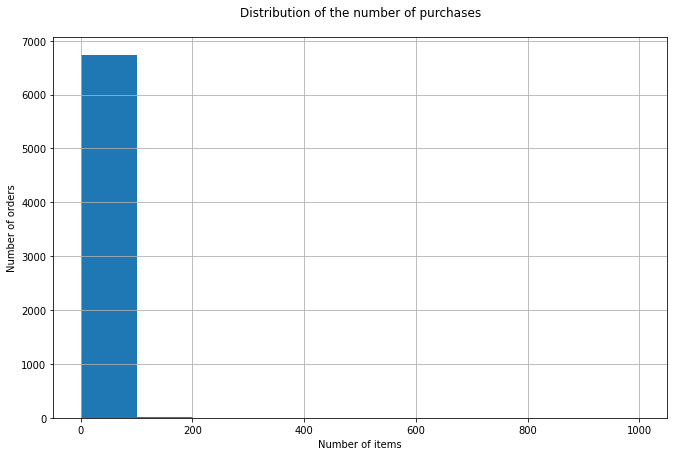

count    6737.000000
mean        2.501559
std        15.266478
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max      1000.000000
Name: quantity, dtype: float64

26.640000000000327

In [5]:
# looking at the distribution of the number of purchases
df['quantity'].hist(figsize=(11,7))
plt.title('Distribution of the number of purchases'+'\n')
plt.ylabel('Number of orders')
plt.xlabel('Number of items')
plt.show()
display(df.quantity.describe())
percentile_quantity = np.percentile(df.quantity, [99])
percentile_quantity.max()

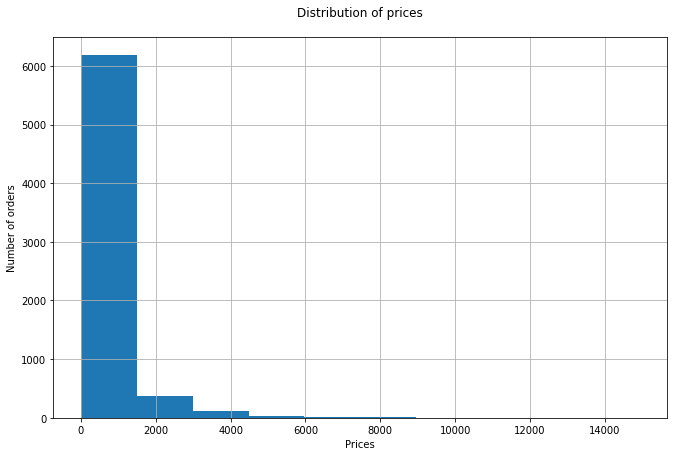

4225.400000000044

In [6]:
# посмотрим на распределение цены
df['price'].hist(figsize=(11,7))
plt.title('Distribution of prices'+'\n')
plt.ylabel('Number of orders')
plt.xlabel('Prices')
plt.show()
percentile_price = np.percentile(df.price, [99])
percentile_price.max()

In [7]:
# what is the period of time in the dataset? 
display(df['date'].min(), df['date'].max())

Timestamp('2018-10-01 00:00:00')

Timestamp('2019-10-31 16:00:00')

In [8]:
# cleaning the dataset from the outliers 
df_no_outliers = df.query('quantity < @percentile_quantity and price < @percentile_price')

In [9]:
# looking at the new data
display(df_no_outliers.info(), df_no_outliers.describe())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6601 entries, 0 to 6736
Data columns (total 6 columns):
date           6601 non-null datetime64[ns]
customer_id    6601 non-null object
order_id       6601 non-null int64
product        6601 non-null object
quantity       6601 non-null int64
price          6601 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 361.0+ KB


None

,order_id,quantity,price
count,6601.000000,6601.000000,6601.000000
mean,42561.791698,1.701409,408.649447
std,27900.499469,2.533308,655.993347
min,12624.000000,1.000000,9.000000
25%,14819.000000,1.000000,104.000000
50%,14943.000000,1.000000,135.000000
75%,70447.000000,1.000000,375.000000
max,73164.000000,26.000000,4139.000000


## Segmenting customers using RFM analysis.<a id='step2'></a>

### The data don't have outliers, they are ready for the RFM analysis. Segmentation of customers in RFM analysis is done using three parameters: R-recency (time from the last purchase), F-frequency (how often a customer purchases) and M-monetary (how much income is generated by the customer). More precisely about RFM analysis  [here](https://medium.com/analytics-vidhya/customer-segmentation-with-rfm-analysis-kmeans-clustering-32c387d04dfe)

In [10]:
# Division data into 4 percentiles, 4th is the highest one
spend_quartiles = pd.qcut(df_no_outliers['price'], q=4, labels=range(1,5))
df_no_outliers['spent_quartiles'] = spend_quartiles 
df_no_outliers.head()

,date,customer_id,order_id,product,quantity,price,spent_quartiles
0,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Алое Вера, d12, h30",1,142.0,3
1,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,"Комнатное растение в горшке Кофе Арабика, d12,...",1,194.0,3
2,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Радермахера d-12 см h-20 см,1,112.0,2
3,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Хризолидокарпус Лутесценс d-9 см,1,179.0,3
4,2018-10-01,ee47d746-6d2f-4d3c-9622-c31412542920,68477,Циперус Зумула d-12 см h-25 см,1,112.0,2


In [11]:
# calculating timedelta  
display(df.date.min(), df.date.max())
df_no_outliers['min_date'] = '2018-10-01 00:00:00'
df_no_outliers['min_date'] = pd.to_datetime(df_no_outliers['min_date'])
df_no_outliers['time_delta'] = df_no_outliers['date'] - df_no_outliers['min_date']
df_no_outliers.time_delta = df_no_outliers.time_delta/np.timedelta64(1, 'D')
df_no_outliers.time_delta = df_no_outliers.time_delta.astype('int')

Timestamp('2018-10-01 00:00:00')

Timestamp('2019-10-31 16:00:00')

In [12]:
# counting the number of days

snapshot_date = max(df_no_outliers['date']) + datetime.timedelta(days=1)

rfm_data = df_no_outliers.groupby(['customer_id']).agg({
    'customer_id':'count',
    'date':lambda x: (snapshot_date - x.max()).days,
    'price':'sum'
})

# renmaing columns 
rfm_data = rfm_data.rename(columns = {'date':'recency',
                          'customer_id':'frequency',
                          'price':'monetary'})

## Preparation of data for KMeans <a id='step3'></a>

In [13]:
# taking the logarithm 
rfm_normalized = np.log(rfm_data)

# converting to Z-scale
scaler = StandardScaler()
scaler.fit(rfm_normalized)
rfm_normalized = scaler.transform(rfm_normalized)
print('среднее:', rfm_normalized.mean(axis=0).round(2))
print('медиана:', rfm_normalized.std(axis=0).round(2))

среднее: [-0. -0. -0.]
медиана: [1. 1. 1.]


In [14]:
# calculating the optimal number of clusters 
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(rfm_normalized)
    sse[k] = kmeans.inertia_

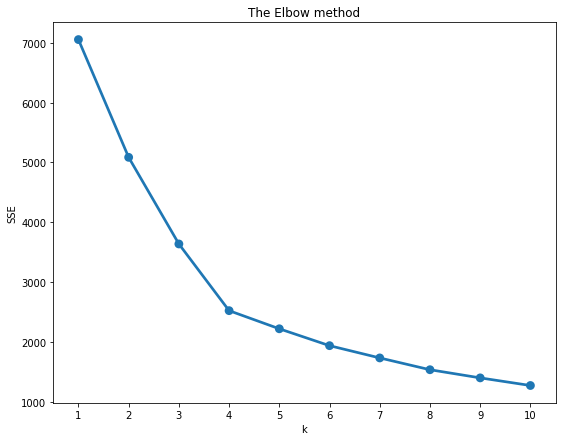

In [15]:
plt.figure(figsize=(9,7))
plt.title('The Elbow method')
plt.xlabel('k'); plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()
# it is clear that the optimal number of cluster is either 3 or 4, let's cluster by both and see which one is better

### Clustering with KMeans <a id='step4'></a>

In [16]:
# calculating statistics for various numbers of clusters 
# calculating for 4 clusters
kmeans_4k = KMeans(n_clusters=4, random_state=1)
kmeans_4k.fit(rfm_normalized)
cluster_labels = kmeans_4k.labels_
df_rfm_k4 = rfm_data.assign(cluster = cluster_labels)

display(df_rfm_k4.groupby('cluster').agg({'recency':'mean',
                                 'frequency':'mean',
                                 'monetary':['mean', 'count']}).round(0))
display(df_rfm_k4.cluster.value_counts())

# for 3 clusters  
kmeans_3k = KMeans(n_clusters=3, random_state=1)
kmeans_3k.fit(rfm_normalized)
cluster_labels = kmeans_3k.labels_
df_rfm_k3 = rfm_data.assign(cluster = cluster_labels)

display(df_rfm_k3.groupby('cluster').agg({'recency':'mean',
                                         'frequency':'mean',
                                         'monetary':['mean', 'count']}).round(0))
display(df_rfm_k3.cluster.value_counts())

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0         246.0       1.0   1283.0  1011
1         222.0      15.0   3689.0   268
2          35.0       1.0    883.0   352
3         222.0       1.0    140.0   720

0    1011
3     720
2     352
1     268
Name: cluster, dtype: int64

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0         223.0      14.0   3674.0   302
1         242.0       1.0    754.0  1635
2          40.0       1.0    859.0   414

1    1635
2     414
0     302
Name: cluster, dtype: int64

In [17]:
# making a dataframe object for a better visualization

df_rfm_normalized_3k = pd.DataFrame(rfm_normalized, 
                                index=rfm_data.index, 
                                columns=rfm_data.columns)
df_rfm_normalized_3k['cluster'] = df_rfm_k3['cluster']

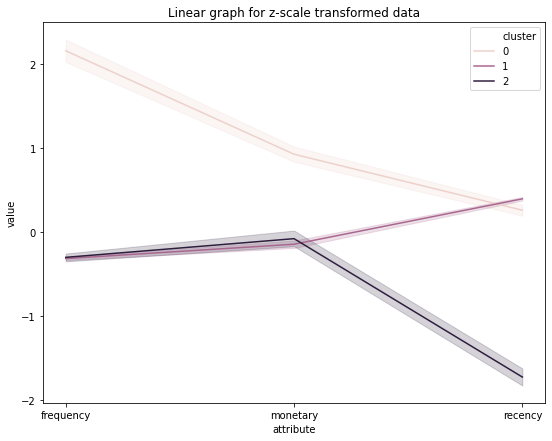

In [18]:
# visualizing clusters 
df_rfm_normalized_3k_melt = pd.melt(df_rfm_normalized_3k.reset_index(),
                                   id_vars=['customer_id', 'cluster'],
                                   value_vars=['recency', 'frequency', 'monetary'],
                                   var_name='attribute',
                                   value_name='value')
plt.figure(figsize=(9,7))
plt.title('Linear graph for z-scale transformed data')
sns.lineplot(x='attribute', y='value', hue='cluster', data=df_rfm_normalized_3k_melt)
plt.show()

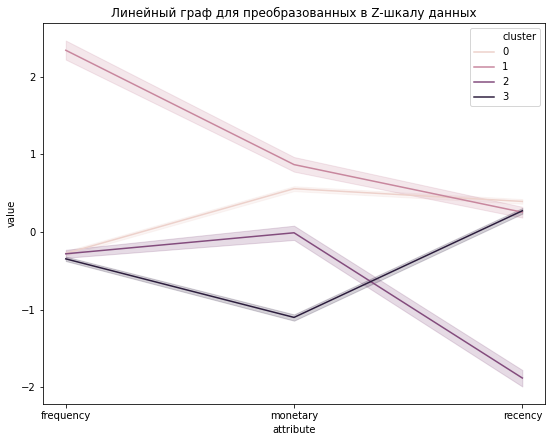

recency frequency monetary      
           mean      mean     mean count
cluster                                 
0         246.0       1.0   1283.0  1011
1         222.0      15.0   3689.0   268
2          35.0       1.0    883.0   352
3         222.0       1.0    140.0   720

0    1011
3     720
2     352
1     268
Name: cluster, dtype: int64

In [19]:
# the same thing for 4 clusters
df_rfm_normalized_4k = pd.DataFrame(rfm_normalized, 
                                index=rfm_data.index, 
                                columns=rfm_data.columns)
df_rfm_normalized_4k['cluster'] = df_rfm_k4['cluster']

# visualizing
df_rfm_normalized_4k_melt = pd.melt(df_rfm_normalized_4k.reset_index(),
                                   id_vars=['customer_id', 'cluster'],
                                   value_vars=['recency', 'frequency', 'monetary'],
                                   var_name='attribute',
                                   value_name='value')
plt.figure(figsize=(9,7))
plt.title('Линейный граф для преобразованных в Z-шкалу данных')
sns.lineplot(x='attribute', y='value', hue='cluster', data=df_rfm_normalized_4k_melt)
plt.show()
display(df_rfm_k4.groupby('cluster').agg({'recency':'mean',
                                 'frequency':'mean',
                                 'monetary':['mean', 'count']}).round(0))
display(df_rfm_k4.cluster.value_counts())

### To sum up: 

- It's seems that the 4-cluster model is more interesting. It stands to reason that it is able to distinct more segments which behave differently. This is also what the elbow method is stating. 0 cluster is the biggest one and it contains users who bought from us long time ago and the average amount if their purchases ~1300. Do we need to send them a push notification to remind of the product? The first cluster contains the most loyal users who generate the most income, purchse frequently, but it's been a while since the last visit. It seems important to address the question whether **they always come with this kind of frequency or has the frequency decreased recently?** The second cluster contains recent users - whose average purchase is for 900 rubles approximately. The last cluster is with 'churned' users. 

## Hypotheses testing <a id='step5'></a>

In [20]:
# Let's keep the 4-cluster model and check if the segments differ significanlty. T-test will be used. There are 4 
# clusters hence 6 comparisons. Consequenly Alpha will be divided by 6 
alpha = 0.05 / 6
def ttest(column_1, column_2, alpha):
    result = st.ttest_ind(column_1, column_2)
    print(column_1.name, column_1.mean())
    print(column_2.name, column_2.mean())
    print('p-value:', result[1])
    if result[1] < alpha:
        print('Rejecting the null hypothesis - the averages of two independent samples are not equal')
    else:
        print('Could not reject the null hypothesis -\
        the difference in the averages of the two independent samples do not differ statistically significant')

Average income by cluster 0


0.5579867357890828

Average income generated by the first cluster


0.8683600614173966

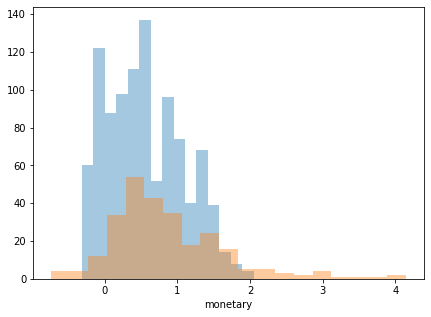

monetary 0.5579867357890828
monetary 0.8683600614173966
p-value: 4.3551988886130714e-14
Rejecting the null hypothesis - the averages of two independent samples are not equal


In [21]:
print('Average income by cluster 0')
display(df_rfm_normalized_4k.query('cluster == 0')['monetary'].mean())
print('Average income generated by the first cluster')
display(df_rfm_normalized_4k.query('cluster == 1')['monetary'].mean())
plt.figure(figsize=(7,5))
sns.distplot(df_rfm_normalized_4k.query('cluster == 0')['monetary'], kde=False)
sns.distplot(df_rfm_normalized_4k.query('cluster == 1')['monetary'], kde=False)
plt.show()
ttest(df_rfm_normalized_4k.query('cluster == 0')['monetary'], 
df_rfm_normalized_4k.query('cluster == 1')['monetary'], alpha)

Average income by cluster 0


0.5579867357890828

Average income generated by the second cluster


-0.01056289869722964

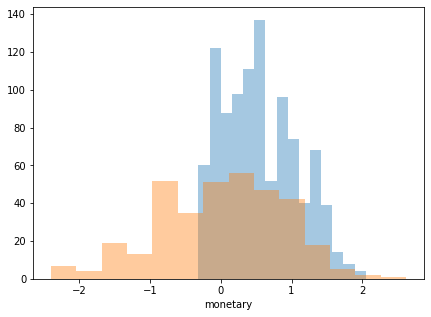

monetary 0.5579867357890828
monetary -0.01056289869722964
p-value: 2.1513383738940287e-43
Rejecting the null hypothesis - the averages of two independent samples are not equal


In [22]:
print('Average income by cluster 0')
display(df_rfm_normalized_4k.query('cluster == 0')['monetary'].mean())
print('Average income generated by the second cluster')
display(df_rfm_normalized_4k.query('cluster == 2')['monetary'].mean())
plt.figure(figsize=(7,5))
sns.distplot(df_rfm_normalized_4k.query('cluster == 0')['monetary'], kde=False)
sns.distplot(df_rfm_normalized_4k.query('cluster == 2')['monetary'], kde=False)
plt.show()
ttest(df_rfm_normalized_4k.query('cluster == 0')['monetary'], 
df_rfm_normalized_4k.query('cluster == 2')['monetary'], alpha)

Average income by cluster 0


0.5579867357890828

Average income generated by the third cluster


-1.1015652027794434

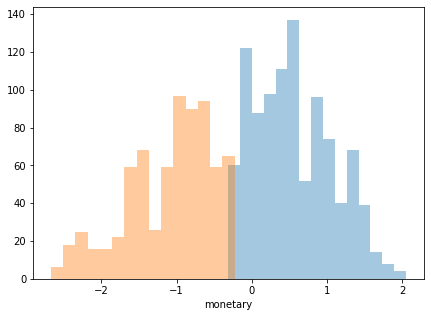

monetary 0.5579867357890828
monetary -1.1015652027794434
p-value: 0.0
Rejecting the null hypothesis - the averages of two independent samples are not equal


In [23]:
print('Average income by cluster 0')
display(df_rfm_normalized_4k.query('cluster == 0')['monetary'].mean())
print('Average income generated by the third cluster')
display(df_rfm_normalized_4k.query('cluster == 3')['monetary'].mean())
plt.figure(figsize=(7,5))
sns.distplot(df_rfm_normalized_4k.query('cluster == 0')['monetary'], kde=False)
sns.distplot(df_rfm_normalized_4k.query('cluster == 3')['monetary'], kde=False)
plt.show()
ttest(df_rfm_normalized_4k.query('cluster == 0')['monetary'], 
df_rfm_normalized_4k.query('cluster == 3')['monetary'], alpha)

Average income generated by the first cluster


0.8683600614173966

Average income generated by the third cluster


-1.1015652027794434

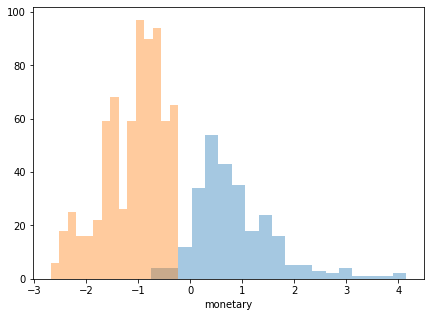

monetary 0.8683600614173966
monetary -1.1015652027794434
p-value: 6.874451454588316e-230
Rejecting the null hypothesis - the averages of two independent samples are not equal


In [24]:
print('Average income generated by the first cluster')
display(df_rfm_normalized_4k.query('cluster == 1')['monetary'].mean())
print('Average income generated by the third cluster')
display(df_rfm_normalized_4k.query('cluster == 3')['monetary'].mean())
plt.figure(figsize=(7,5))
sns.distplot(df_rfm_normalized_4k.query('cluster == 1')['monetary'], kde=False)
sns.distplot(df_rfm_normalized_4k.query('cluster == 3')['monetary'], kde=False)
plt.show()
ttest(df_rfm_normalized_4k.query('cluster == 1')['monetary'], 
df_rfm_normalized_4k.query('cluster == 3')['monetary'], alpha)

Average income generated by the first cluster


0.8683600614173966

Average income generated by the second cluster


-0.01056289869722964

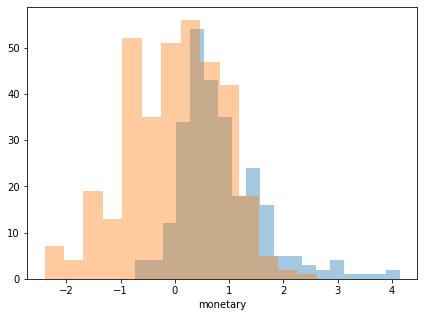

monetary 0.8683600614173966
monetary -0.01056289869722964
p-value: 3.113122463368047e-33
Rejecting the null hypothesis - the averages of two independent samples are not equal


In [25]:
print('Average income generated by the first cluster')
display(df_rfm_normalized_4k.query('cluster == 1')['monetary'].mean())
print('Average income generated by the second cluster')
display(df_rfm_normalized_4k.query('cluster == 2')['monetary'].mean())
plt.figure(figsize=(7,5))
sns.distplot(df_rfm_normalized_4k.query('cluster == 1')['monetary'], kde=False)
sns.distplot(df_rfm_normalized_4k.query('cluster == 2')['monetary'], kde=False)
plt.show()
ttest(df_rfm_normalized_4k.query('cluster == 1')['monetary'], 
df_rfm_normalized_4k.query('cluster == 2')['monetary'], alpha)

Average income generated by the second cluster


-0.01056289869722964

Average income generated by the third cluster


-1.1015652027794434

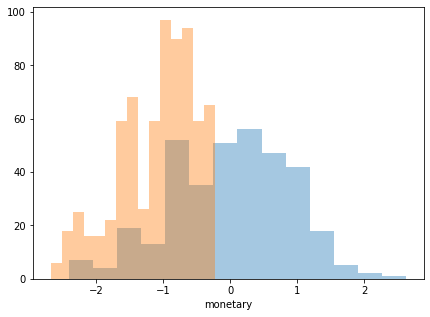

monetary -0.01056289869722964
monetary -1.1015652027794434
p-value: 1.2284718501275584e-103
Rejecting the null hypothesis - the averages of two independent samples are not equal


In [26]:
print('Average income generated by the second cluster')
display(df_rfm_normalized_4k.query('cluster == 2')['monetary'].mean())
print('Average income generated by the third cluster')
display(df_rfm_normalized_4k.query('cluster == 3')['monetary'].mean())
plt.figure(figsize=(7,5))
sns.distplot(df_rfm_normalized_4k.query('cluster == 2')['monetary'], kde=False)
sns.distplot(df_rfm_normalized_4k.query('cluster == 3')['monetary'], kde=False)
plt.show()
ttest(df_rfm_normalized_4k.query('cluster == 2')['monetary'], 
df_rfm_normalized_4k.query('cluster == 3')['monetary'], alpha)

cluster,0,1,2,3
monetary,1282.90999,3689.272388,882.730114,140.315278


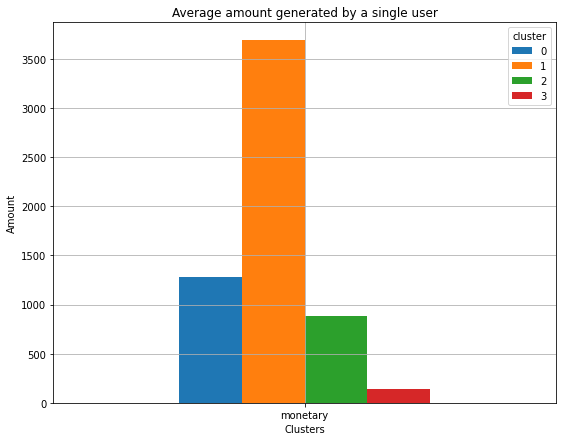

In [27]:
pivot = df_rfm_k4.pivot_table(columns='cluster', values='monetary', aggfunc='mean')
display(pivot)
pivot.plot.bar(grid=True, figsize=(9,7))
pivot.astype('int')
plt.title('Average amount generated by a single user')
plt.xlabel('Clusters')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.show()

0    1011
3     720
2     352
1     268
Name: cluster, dtype: int64

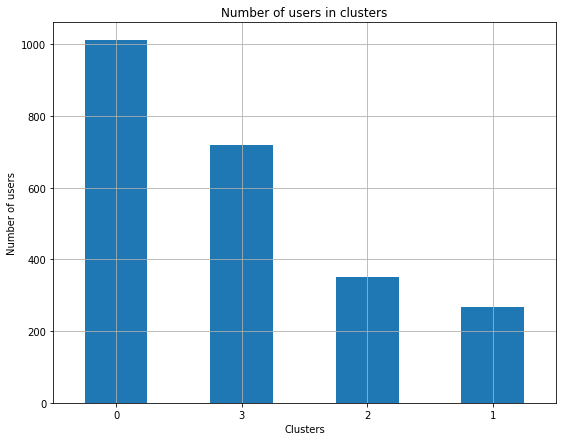

In [28]:
display(df_rfm_k4.cluster.value_counts())
df_rfm_k4.cluster.value_counts().plot(kind='bar', figsize=(9,7), 
                                     grid=True)
plt.title('Number of users in clusters')
plt.xlabel('Clusters')
plt.ylabel('Number of users')
plt.xticks(rotation=0)
plt.show()

,frequency
cluster,
0,1.267062
1,14.947761
2,1.309659
3,1.184722


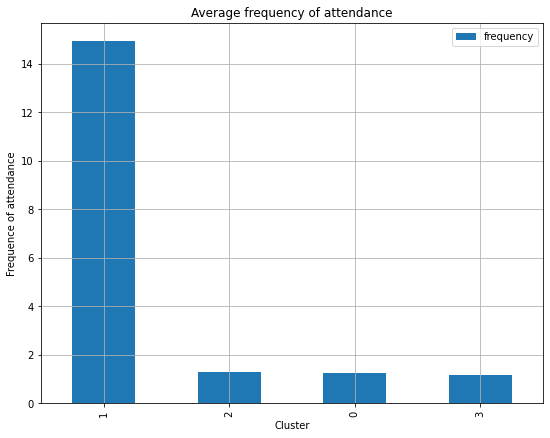

In [29]:
display(df_rfm_k4.groupby('cluster').agg({'frequency':'mean'}))
df_rfm_k4.groupby('cluster').agg({'frequency':'mean'}).\
sort_values(by='frequency', ascending=False).\
plot.bar(figsize=(9,7), grid=True)
plt.title('Average frequency of attendance')
plt.xlabel('Cluster')
plt.ylabel('Frequence of attendance')
plt.show()

,recency
cluster,
0,245.803165
1,222.220149
2,35.312500
3,221.772222


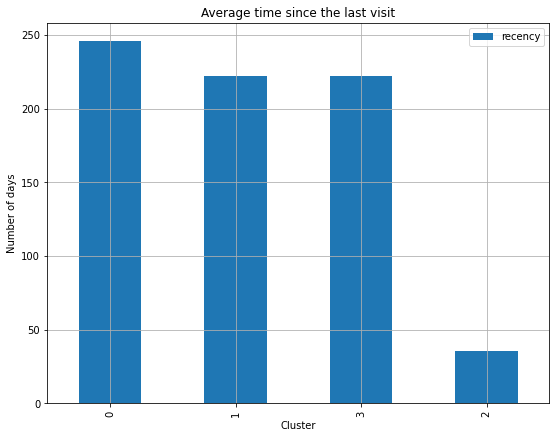

In [30]:
display(df_rfm_k4.groupby('cluster').agg({'recency':'mean'}))
df_rfm_k4.groupby('cluster').agg({'recency':'mean'}).\
sort_values(by='recency', ascending=False).\
plot.bar(figsize=(9,7), grid=True)
plt.title('Average time since the last visit')
plt.xlabel('Cluster')
plt.ylabel('Number of days')
plt.show()

### To sum up:

There was conducted a study which purpose was to segment customers. The primary tool was RFM analysis. There were detected 4 segments:  

- **The zero segment.** Users buy from us about once a year. The average purchase amount in this segment is about 1300 rubles. Approximately 43% of users fall into this segment


- **The first segment.** Users in the first segment are the most loyal and bring us the most profit. On average, they come to us 15 times and their average purchase is about 3700 rubles. On average, the most loyal users buy from us once every seven months. We have about 11% of such users.


- **The second segment.** They are the most recent users. Their average purchase is about 900 rubles. On average, they buy from us once and there are about 15 percent of them.


- **The third segment.** Those are the clients who 'churned'. They used to buy a long time ago - 222 days ago on average, average amount of their purchases - 140 rubles and they only bought once. They are 31%.
